In [2]:
!pip install seaborn

from ipyaggrid import Grid
import pandas as pd
from IPython.display import display
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
import numpy as np

import matplotlib.pyplot as plt
import squarify    # pip install squarify (algorithm for treemap)

# Making Pandas display more than a few rows and columns at a time by default.
# Surprising that Pandas doesn't fix this by now...
pd.set_option('display.max_rows', 500)

In [3]:
# Importing dataframes from their sources

dfm_fool = pd.read_csv('results/fool.csv')
dfm_zacks = pd.read_csv('results/zacks.csv')

In [4]:
# Aggrid settings

grid_options = {
    #'columnDefs' : column_defs,
    'enableSorting': True,
    'enableFilter': True,
    'enableColResize': True,
    'enableRangeSelection': True,
     'enableCharts': True
}

In [5]:
def make_aggrid(df):
    grid_options = {
    #'columnDefs' : column_defs,
    'enableSorting': True,
    'enableFilter': True,
    'enableColResize': True,
    'enableRangeSelection': True,
}
    g = Grid(grid_data=df,
         grid_options=grid_options,
         quick_filter=True,
         show_toggle_edit=True,
         export_mode="buttons",
         export_csv=True,
         export_excel=True,
         theme='ag-theme-balham',
         show_toggle_delete=True,
         columns_fit='auto',
         index=False,
         keep_multiindex=False)
    return g

In [6]:
# Creating an instance of an Ag grid.

g = Grid(grid_data=dfm_fool,
         grid_options=grid_options,
         quick_filter=True,
         show_toggle_edit=True,
         export_mode="buttons",
         export_csv=True,
         export_excel=True,
         theme='ag-theme-balham',
         show_toggle_delete=True,
         columns_fit='auto',
         index=False,
         keep_multiindex=False)


In [7]:
print(dfm_zacks.columns.tolist())
print(dfm_fool.columns.tolist())

['Unnamed: 0', 'zacks_consensus', 'zacks_URL']
['Unnamed: 0', 'fool_rating', 'fool_url']


In [8]:
# Splitting out the symbol (since the original summary files didn't contain it...)
# Makes the table join below possible.

new_fool_url = dfm_fool['fool_url'].str.split('/',expand=True)
new_zacks_url = dfm_zacks['zacks_URL'].str.split('/', expand=True)


dfm_fool['symbol'] = new_fool_url[4]
dfm_zacks['symbol'] = new_zacks_url[5]

In [9]:
# left join results into reference source (the dow jones company list)

all_stocks = pd.read_csv('companylist.csv')
print(all_stocks.columns)

# Displaying all columns (since ag grid does some weird capitalization when displaying.)
all_stocks.columns = map(str.lower, all_stocks.columns)


Index(['Symbol', 'Name', 'LastSale', 'MarketCap', 'IPOyear', 'Sector',
       'industry', 'Summary Quote', 'Unnamed: 8'],
      dtype='object')


In [10]:
dfs = [all_stocks, dfm_fool, dfm_zacks]

# Join from above on symbol
df_final = reduce(lambda left,right: pd.merge(left,right,on='symbol'), dfs)

# Convert Marketcap string to integer

df_final['marketcap'] = df_final['marketcap'].str[1:]
df_final['marketcap_multiplier'] = df_final['marketcap'].str[-1]
df_final['marketcap'] = df_final['marketcap'].str[:-1]


# Re-casting this column is done in-place.  Be careful about the column matches.
# Note that I had to continuously operate on the new calcualated column after the second replacement.

df_final['marketcap_multiplier_int'] = df_final['marketcap_multiplier'].replace('M',1000000)
df_final['marketcap_multiplier_int'] = df_final['marketcap_multiplier_int'].replace('B',1000000000)
df_final['marketcap_multiplier_int'] = df_final['marketcap_multiplier_int'].replace('T',1000000000000)

df_final['marketcap_multiplier_int'] = pd.to_numeric(df_final['marketcap_multiplier_int'])
df_final['marketcap'] = pd.to_numeric(df_final['marketcap'])

df_final['marketcap'] = df_final['marketcap'] * df_final['marketcap_multiplier_int']




In [11]:
# Apply some filters
df_final = df_final[df_final['zacks_consensus'] == 'Strong Buy']
df_final = df_final[df_final['fool_rating'] == '5']

# Slice some columns
df_final = df_final.loc[:,['symbol', 'name','marketcap','ipoyear','sector','industry', 'marketcap_multiplier']]

df_final['marketcap'] = df_final['marketcap'].fillna(10)
df_final['sector'] = df_final['sector'].fillna('Unknown')


df_final['marketcap_log'] = np.log10(df_final['marketcap'])


# Display prefiltered view.
make_aggrid(df_final)

Grid(columns_fit='auto', compress_data=True, export_mode='buttons', height='350px', menu={'buttons': [{'name':…

['Transportation', 'Technology', 'Finance', 'Finance', 'Health Care', 'Health Care', 'Health Care', 'Health Care', 'Finance', 'Health Care', 'Consumer Durables', 'Technology']
['Transportation', 'Technology', 'Finance', 'Finance', 'Health Care', 'Health Care', 'Health Care', 'Health Care', 'Finance', 'Health Care', 'Consumer Durables', 'Technology']


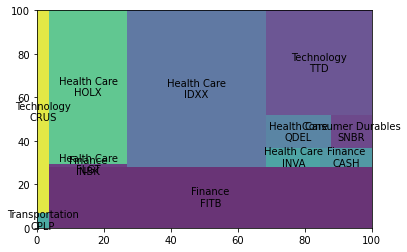

<Figure size 432x288 with 0 Axes>

In [12]:
print(list(df_final['sector']))

columns = [x for x in list(df_final['sector']) if str(x) != 'nan']

print(columns)



colors = ['red' for x in df_final['sector'] if x.find('Health') > 0]

squarify.plot(sizes=df_final['marketcap'], label=df_final['sector'] + "\n" + df_final['symbol'], alpha=.8 )
plt.figure()
    
plt.show()